In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import median
from scipy import stats
from scipy import special
%matplotlib inline

In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

### Transform data to normal distribution

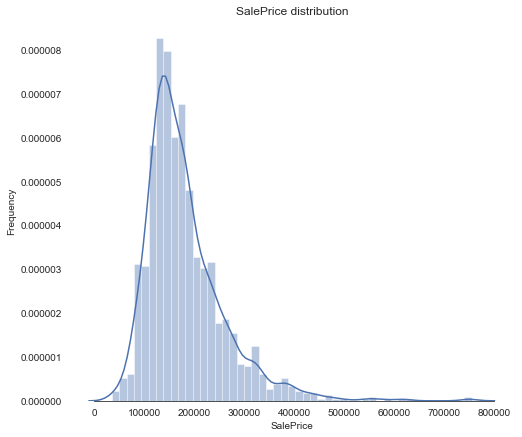

In [4]:
sns.set_style("white")
sns.set_color_codes(palette='deep')

f, ax = plt.subplots(figsize=(8, 7))

#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");

ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

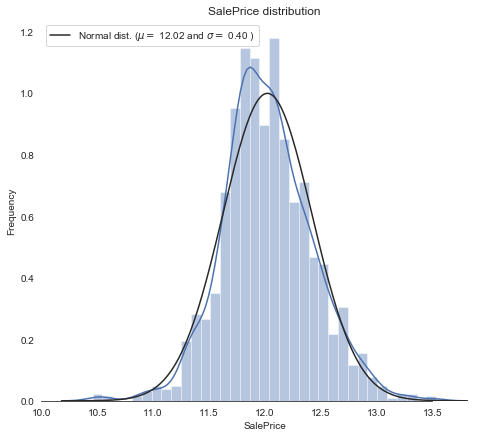

In [5]:
# log(1+x) 转换
train["SalePrice_log"] = np.log1p(train["SalePrice"])

sns.set_style("white")
sns.set_color_codes(palette='deep')

f, ax = plt.subplots(figsize=(8, 7))

sns.distplot(train['SalePrice_log'] , fit=stats.norm, color="b");

# 用正态分布拟合并得到正态分布的参数
(mu, sigma) = stats.norm.fit(train['SalePrice_log']) 

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

### Find skewed features

我们对数据集进行分析，首先我们可以先看看特征的分布情况，看下哪些特征明显就是有数据倾斜的，然后可以找办法解决，因此，第一步就是要有办法找到这些特征。 首先可以通过可视化的方式，画箱体图，然后观察箱体情况，理论知识是：
在箱线图中，箱子的中间有一条线，代表了数据的中位数。箱子的上下底，分别是数据的上四分位数（Q3）和下四分位数（Q1），这意味着箱体包含了50%的数据。因此，箱子的高度在一定程度上反映了数据的波动程度。上下边缘则代表了该组数据的最大值和最小值。有时候箱子外部会有一些点，可以理解为数据中的“异常值”。而对于数据倾斜的，我们叫做“偏态”，与正态分布相对，指的是非对称分布的偏斜状态。在统计学上，众数和平均数之差可作为分配偏态的指标之一：如平均数大于众数，称为正偏态（或右偏态）；相反，则称为负偏态（或左偏态）。

上四分位我们设为 U，表示的是所有样本中只有1/4的数值大于U
同理，下四分位我们设为 L，表示的是所有样本中只有1/4的数值小于L
我们设上四分位与下四分位的差值为IQR，即：IQR=U-L
那么，上界为 U+1.5IQR ，下界为： L - 1.5IQR

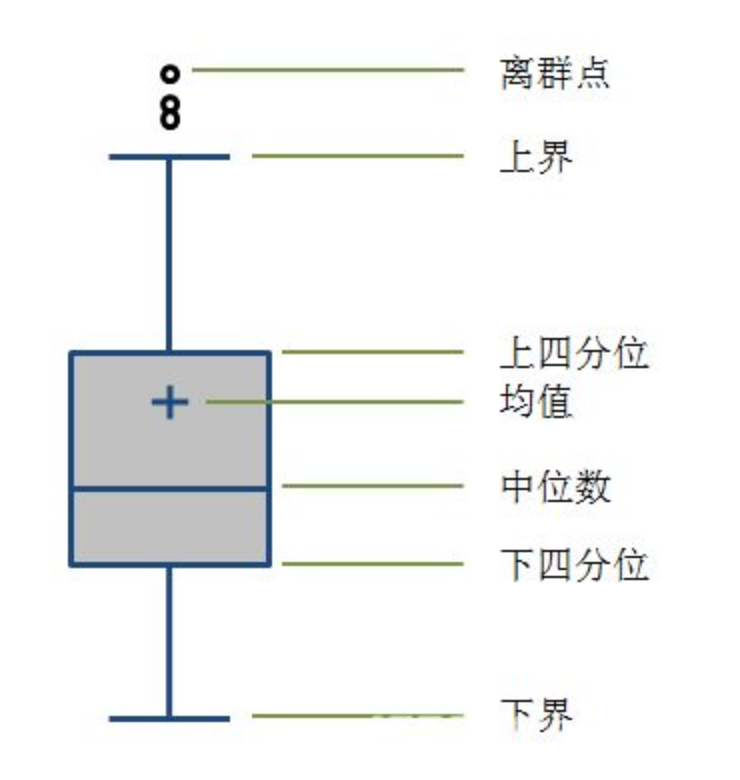

In [1]:
from IPython.display import Image
Image(filename='box.png')

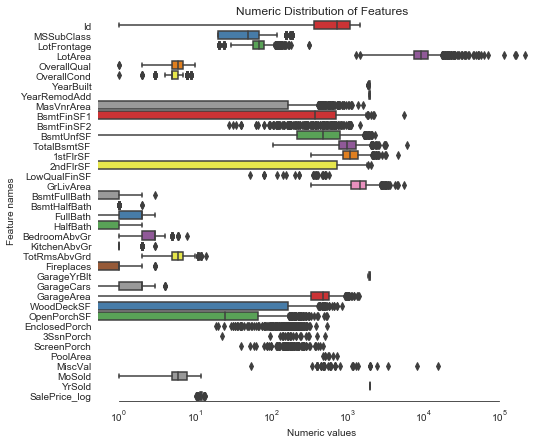

In [6]:
# 丢弃y值
all_features = train.drop(['SalePrice'], axis=1)

# 找出所有的数值型变量
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)
        
# 对所有的数值型变量绘制箱体图
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

可以看出有一些特征，有一些数据会偏离箱体外，因此属于数据倾斜。但是，我们从上面的可视化中虽然看出来了，但是想要选出来还是比较麻烦，所以这里引入一个偏态的概念，相对应的有一个指标skew，这个就是代表偏态的系数。

Skewness：描述数据分布形态的统计量，其描述的是某总体取值分布的对称性，简单来说就是数据的不对称程度。

偏度是三阶中心距计算出来的。

（1）Skewness = 0 ，分布形态与正态分布偏度相同。

（2）Skewness > 0 ，正偏差数值较大，为正偏或右偏。长尾巴拖在右边，数据右端有较多的极端值。

（3）Skewness < 0 ，负偏差数值较大，为负偏或左偏。长尾巴拖在左边，数据左端有较多的极端值。

（4）数值的绝对值越大，表明数据分布越不对称，偏斜程度大。

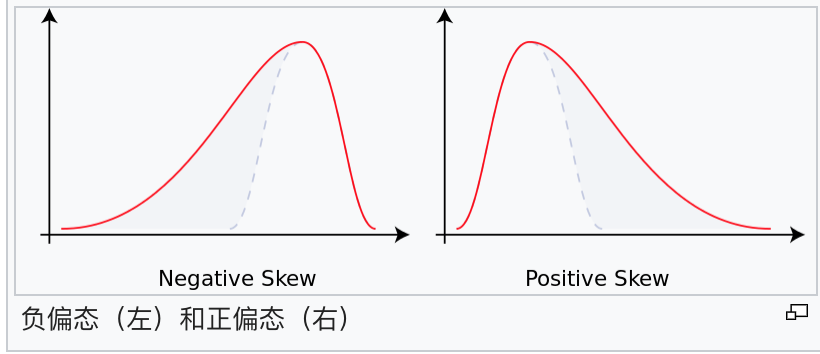

In [7]:
from IPython.display import Image
Image(filename='skewness.png')

In [8]:
# 找出明显偏态的数值型变量
skew_features = all_features[numeric].apply(lambda x: stats.skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("本数据集中有 {} 个数值型变量的 Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

本数据集中有 24 个数值型变量的 Skew > 0.5 :


MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
dtype: float64

### Repair skewed features by Box-Cox

我们通过上次的知识，知道了可以通过skewness来进行倾斜特征的辨别，那么对于修正它的办法，这里也先分享一个理论知识 —— box-cox转换。

线性回归模型满足线性性、独立性、方差齐性以及正态性的同时，又不丢失信息，此种变换称之为Box—Cox变换。

Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性，对许多实际数据都是行之有效的。—— 百度百科

In [9]:
for i in skew_index:
    all_features[i] = special.boxcox1p(all_features[i], stats.boxcox_normmax(all_features[i] + 1))

/Users/FY/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/FY/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


然后我们再看看还有多少个数据倾斜的特征吧！

In [10]:
# 找出明显偏态的数值型变量
skew_features = all_features[numeric].apply(lambda x: stats.skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("本数据集中有 {} 个数值型变量的 Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})

本数据集中有 15 个数值型变量的 Skew > 0.5 :


变少了很多，而且如果看他们的skew值，也会发现变小了很多。我们也可以看看转换后的箱体图情况。

/Users/FY/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:486: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  **kws)


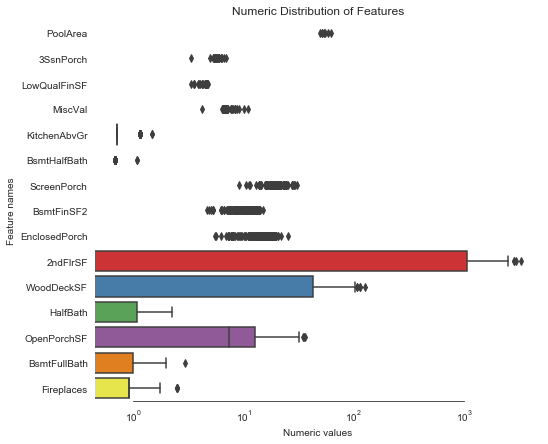

In [11]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)